# BATADAL - Bonus Task: Deep Neural Networks

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/%28ASCE%29WR.1943-5452.0000969)).

The purpose of this bonus task is to use PyTorch (or another framework) to learn Deep Neural Networks for anomaly detection as discussed in class and in the literature. Try out different learning rates and detection thresholds. Compare the performance with the other three approaches (ARMA, n-grams and PCA). Do you recommend using Deep Learning? Why (not)?

**Package requirement**: keras, pydot, graphviz

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_recall_curve, 
                             roc_curve, auc)
from tensorflow import set_random_seed

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(42)
set_random_seed(42)

seed = 42

## 0. Description of the datasets

Three BATADAL datasets (R. Taormina et al, 2018) are available:

1. *Training dataset 1:* A one-year long simulation data, does not contain any attacks, i.e., all te data pertains to C-Town normal operations.
2. *Training dataset 2:* Partially labelled data of around 6 months long and contains several attacks, some of which are approximately labelled.
3. *Test dataset:* A 3-months long dataset which contains several attacks but no labels. Supposed to be used to compare the performance of the algorithms.

*In this bonus task we use only the all three datasets to demonstrate our work.*

In [3]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')
dftrain2 = pd.read_csv('./data/BATADAL_dataset04.csv')
dftest = pd.read_csv('./data/BATADAL_test_dataset.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

# Remove the spaces in column names
dftrain2.columns = dftrain2.columns.str.strip()

## 1. Data preparation

We first start with data preparation.

In [4]:
def time_slicing(df_to_sliced, n=10):
    ## training datasets : time slicing with length = n hrs 
    # for x in dataset
    df_x = [df.values.reshape(-1) for g, df in df_to_sliced.groupby(np.arange(len(df_to_sliced)) // n)]
    df_x = pd.DataFrame(df_x)
    
    # for y in dataset : expected predicted result
    df_y = df_x.iloc[:, :len(df_to_sliced.columns)].shift(-1) # the first batch of columns in the flattened data
    df_y.columns = df_to_sliced.columns
    
    # remove the last rows for both training dataset x and y
    df_x.drop(df_x.tail(1).index, inplace = True)
    df_y.drop(df_y.tail(1).index, inplace = True)
    
    return df_x, df_y

### 1.1 Training dataset

We'd like to train the model with only normal data. Therefore, here we use the whole training dataset #1 for it.

In [5]:
# assign size per slice
n_slice = 5

In [6]:
# prepare training dataset
train = dftrain1.copy()
train.drop(columns = ['DATETIME', 'ATT_FLAG'], inplace = True)
train_x, train_y = time_slicing(train, n=10)

train_x.shape, train_y.shape

((876, 430), (876, 43))

### 1.2 Validating dataset

The validating dataset contains both normal and attacked activities. Therefore, here we use the whole training dataset #2 for it.

In [7]:
# prepare validating dataset (for model input, without labels)
validate = dftrain2.copy()
validate.drop(columns = ['DATETIME', 'ATT_FLAG'], inplace = True)
validate_x, validate_y = time_slicing(validate, n=10)

validate_x.shape, validate_y.shape

((417, 430), (417, 43))

In [8]:
# prepare the labels for validating dataset
validate_label = dftrain2.copy()
validate_label.drop(columns = ['DATETIME'], inplace = True)
_, validate_label = time_slicing(validate_label, n=10)
validate_label.loc[validate_label['ATT_FLAG'] == -999] =0

validate_label.shape

(417, 44)

### 1.3 Testing dataset

In [9]:
# prepare testing dataset
dftest['ATT_FLAG'] = 0

# assign labels to attacks in testing dataset
attacks_in_test = [['16/01/2017 09', '19/01/2017 06'],
                   ['30/01/2017 08', '02/02/2017 00'],
                   ['09/02/2017 03', '10/02/2017 09'],
                   ['12/02/2017 01', '13/02/2017 07'],
                   ['24/02/2017 05', '28/02/2017 08'],
                   ['10/03/2017 14', '13/03/2017 21'],
                   ['25/03/2017 20', '27/03/2017 01']]

for period in attacks_in_test:
    i = pd.to_datetime(period[0], format = '%d/%m/%Y %H') #starting time
    j = pd.to_datetime(period[1], format = '%d/%m/%Y %H') #ending time
    i = int(np.where(dftest.DATETIME == i)[0])
    j = int(np.where(dftest.DATETIME == j)[0])
    dftest.loc[i:j, 'ATT_FLAG'] = 1 #label the attack

In [10]:
# split into x and y
test = dftest.copy()
test.drop(columns = ['DATETIME', 'ATT_FLAG'], inplace = True)
test_x, test_y = time_slicing(test, n=10)

test_x.shape, test_y.shape

((208, 430), (208, 43))

In [11]:
# prepare the labels for validating testing dataset
test_label = dftest.copy()
test_label.drop(columns = ['DATETIME'], inplace = True)
_, test_label = time_slicing(test_label, n=10)
test_label.loc[test_label['ATT_FLAG'] == -999] =0

test_label.shape

(208, 44)

## 2. Deep neural network model

We hereby contruct a simple deep neural network model with different learning rates and see the differences in results.

In this script, validating the performance of anomaly detection is done by **counting a true positive if it detects at least one anomaly in an anomalous region**. More specifically, if at least one anomaly is detected in the anomalous region, we say all the data points in that region are true positive.

The task is demonstrated under three different learning rates: 1e-2, 1e-3, and 1e-4.

### 2.1 Model construction

We start with building a (simple) autoencoder.

In [12]:
# a simple autoencoder
def autoencoder(learning_rate):
    # a simple autoencoder
    input_dim = train_x.shape[1]
    output_dim = train_y.shape[1]

    model = Sequential()
    model.add(Dense(int(input_dim/10), input_dim = input_dim, activation='relu', activity_regularizer=regularizers.l1(learning_rate)))
    model.add(Dense(int(input_dim/20), activation='relu'))
    model.add(Dense(int(input_dim/20), activation='sigmoid'))
    model.add(Dense(output_dim, activation='relu'))

    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [13]:
# assign parameters
nr_epochs = 100
batch_size = 64

In [14]:
# assign learning rate
learning_rate = 1e-2

model = autoencoder(learning_rate = learning_rate)
model.fit(train_x, train_y,
          epochs = nr_epochs,
          batch_size = batch_size,
          shuffle = True,
          validation_split = 0.2)

Train on 700 samples, validate on 176 samples
Epoch 1/100
700/700 [==============================] - 2s 3ms/step - loss: 1297.0306 - acc: 0.0029 - val_loss: 1240.4842 - val_acc: 0.0057
Epoch 2/100
700/700 [==============================] - 0s 58us/step - loss: 1227.4995 - acc: 0.0043 - val_loss: 1205.0513 - val_acc: 0.0057
Epoch 3/100
700/700 [==============================] - 0s 67us/step - loss: 1186.6868 - acc: 0.0043 - val_loss: 1154.2171 - val_acc: 0.0057
Epoch 4/100
700/700 [==============================] - 0s 77us/step - loss: 1121.5768 - acc: 0.0043 - val_loss: 1074.2539 - val_acc: 0.0057
Epoch 5/100
700/700 [==============================] - 0s 84us/step - loss: 1042.6778 - acc: 0.0043 - val_loss: 1005.1185 - val_acc: 0.0057
Epoch 6/100
700/700 [==============================] - 0s 70us/step - loss: 983.2470 - acc: 0.0043 - val_loss: 955.8438 - val_acc: 0.0057
Epoch 7/100
700/700 [==============================] - 0s 70us/step - loss: 939.3283 - acc: 0.0043 - val_loss: 917.96

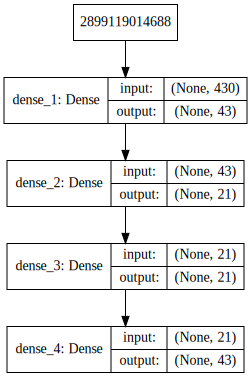

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

### 2.2 Validation

Validate the results by using the validating dataset (training dataset #2) and set the threshold accordingly.

In [16]:
# validate the results
def validation(model, learning_rate):
    validate_pred = model.predict(validate_x) # predict with training dataset #2

    # calculate reconstruction error
    rmse = np.mean(np.power(validate_y - validate_pred, 2), axis=1)

    # compare the reconstruction error to true class
    error_df = pd.DataFrame({'Reconstruction_error': rmse,
                             'True_class': validate_label['ATT_FLAG']})
    error_df.reset_index(inplace = True)
    return error_df, rmse

In [17]:
def plot_precision_recall_curve(error_df, learning_rate):
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

    plt.plot(threshold_rt, precision_rt[1:], label = "Precision", linewidth = 3)
    plt.plot(threshold_rt, recall_rt[1:], label = "Recall", linewidth = 3)
    plt.title('Precision and recall for different threshold values\nLearning rate = {}'.format(learning_rate))
    plt.xlabel('Reconstruction error (Threshold)')
    plt.ylabel('Precision / Recall')
    plt.legend()

In [18]:
def plot_error(error_df, threshold_fixed = False):
    # plot the results
    fig, ax = plt.subplots()

    for g, df in error_df.groupby('True_class'):
        ax.plot(df.index, df.Reconstruction_error,
                marker='o', ms=3.5, linestyle='',
                label = 'Attack' if g == 1 else 'Normal')
    if (threshold_fixed) | (type(threshold_fixed) == int):
        ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
                  linestyle = '--', colors='r', label='Threshold')
    ax.legend(loc = 'lower right')
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")

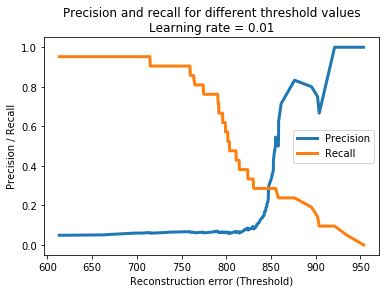

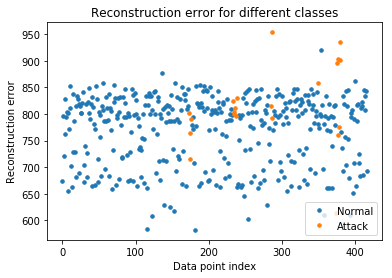

In [19]:
# predict the results for validating dataset
error_df, rmse = validation(model, learning_rate)

plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df) # plot data points vs threshold

According to above graphs, assign a reconstruction error threshold, and overwrite fp's to tp's if at least one anomaly is detected in the anomalous region.

In [20]:
# count a true positive if it detects at least one anomaly in an anomalous region
def tp_anomalous_region(error_df, threshold_fixed):
    # label data whose error is above given threshold
    error_df['Detected'] = rmse >= threshold_fixed
    
    # grouping data in anomalous regions
    id_group = np.arange(len(error_df)) # set dummy array for grouping data in anomalous regions
    for i in np.arange(len(error_df)):
        if (error_df.True_class[i] == 1): # if labelled attack
            if (error_df.True_class[i] == error_df.True_class[i-1]):
                id_group[i] = id_group[i-1]
            else: # first index in the region, keep the index
                continue 
        else: # normal data id=0
            id_group[i] = 0
    error_df['Anomalous_region'] = id_group
    
    # if detected at least one anomaly in the anomalous region, overwrite fp to tp
    for g, df in error_df.groupby('Anomalous_region'):
        if g != 0: # if anomalous region
            if df.Detected.any(): # if detects at least one anomaly in the region
                error_df.loc[df.index, 'Detected'] = True # overwrite the whole region to TRUE

    error_df.drop(columns = ['Anomalous_region'], inplace=True)
    return error_df

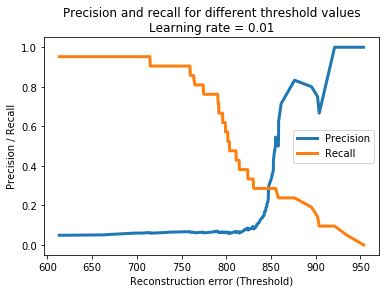

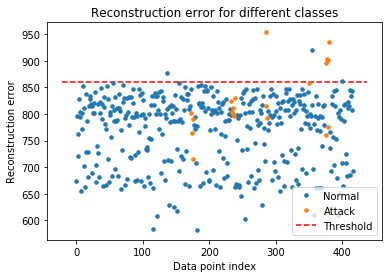

In [21]:
# assign threshold
threshold_fixed = 860

# if detected at least one anomaly in the anomalous region, overwrite fp to tp
error_df = tp_anomalous_region(error_df, threshold_fixed)

# plot the results again
plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df, threshold_fixed)

### 2.3 Evaluation

Evaluate the model using testing dataset with assigned threshold.

In [22]:
# evaluate the results
def evaluation(model, learning_rate):
    test_pred = model.predict(test_x) # predict with training dataset #2

    # calculate reconstruction error
    rmse = np.mean(np.power(test_y - test_pred, 2), axis=1)

    # compare the reconstruction error to true class
    error_df = pd.DataFrame({'Reconstruction_error': rmse,
                             'True_class': test_label['ATT_FLAG']})
    error_df.reset_index(inplace = True)
    return error_df, rmse

In [23]:
def plot_conf_matrix(error_df, threshold_fixed):
    conf_matrix = confusion_matrix(error_df.True_class, error_df.Detected)

    plt.figure()
    sns.heatmap(conf_matrix, xticklabels=["Normal","Attack"], yticklabels=["Normal","Attack"], annot=True, fmt='d');
    plt.title('Confusion matrix: threshold={}'.format(threshold_fixed))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

In [24]:
def plot_roc_curve(error_df, learning_rate, threshold_fixed):
    false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    
    plt.figure()
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=3, linestyle='--')

    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('ROC curve (learning rate = {}, threshold = {})'.format(learning_rate, threshold_fixed))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

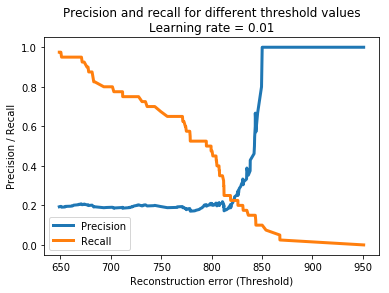

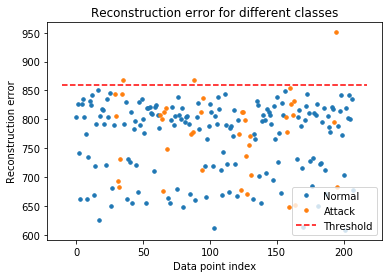

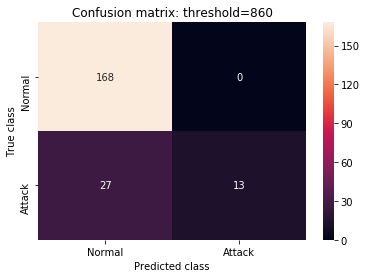

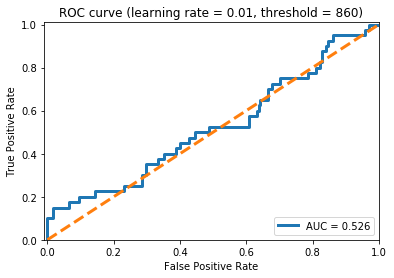

In [25]:
# predict the results for testing dataset
error_df, rmse = evaluation(model, learning_rate)
error_df = tp_anomalous_region(error_df, threshold_fixed)

# plot the results
plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df, threshold_fixed)
plot_conf_matrix(error_df, threshold_fixed)
plot_roc_curve(error_df, learning_rate, threshold_fixed)

### 2.2 Learning rate = 0.001

In [26]:
# assign learning rate
learning_rate = 1e-3

model = autoencoder(learning_rate)

model.fit(train_x, train_y,
          epochs = nr_epochs,
          batch_size = batch_size,
          shuffle = True,
          validation_split = 0.2)

Train on 700 samples, validate on 176 samples
Epoch 1/100
700/700 [==============================] - 0s 336us/step - loss: 1256.6028 - acc: 0.1400 - val_loss: 1206.3163 - val_acc: 0.2614
Epoch 2/100
700/700 [==============================] - 0s 58us/step - loss: 1176.8231 - acc: 0.2614 - val_loss: 1130.2368 - val_acc: 0.2614
Epoch 3/100
700/700 [==============================] - 0s 61us/step - loss: 1071.0642 - acc: 0.2614 - val_loss: 993.8475 - val_acc: 0.2614
Epoch 4/100
700/700 [==============================] - 0s 67us/step - loss: 942.1724 - acc: 0.2614 - val_loss: 882.7718 - val_acc: 0.2614
Epoch 5/100
700/700 [==============================] - 0s 61us/step - loss: 844.3911 - acc: 0.2614 - val_loss: 799.4387 - val_acc: 0.2614
Epoch 6/100
700/700 [==============================] - 0s 58us/step - loss: 769.3069 - acc: 0.2614 - val_loss: 734.0459 - val_acc: 0.2614
Epoch 7/100
700/700 [==============================] - 0s 61us/step - loss: 710.0145 - acc: 0.2614 - val_loss: 682.1989 

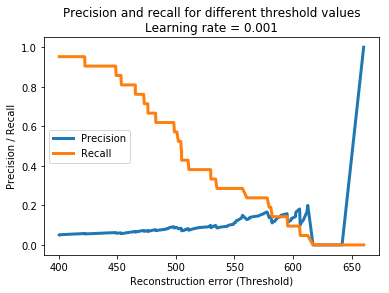

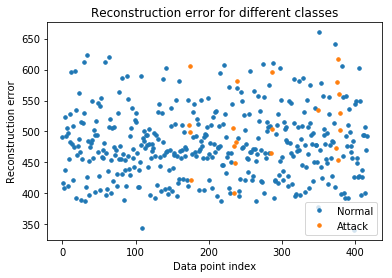

In [27]:
error_df, rmse = validation(model, learning_rate)

# plot the original results (before modification)
plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df)

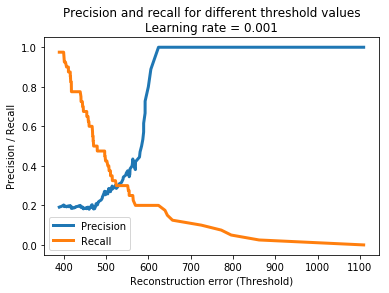

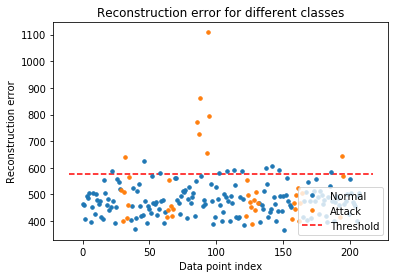

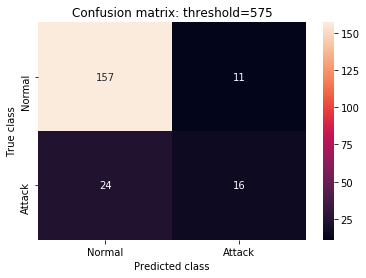

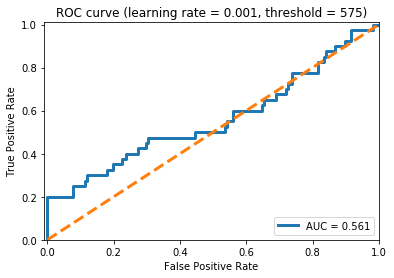

In [28]:
# assign threshold
threshold_fixed = 575

# predict the results for testing dataset
error_df, rmse = evaluation(model, learning_rate)
error_df = tp_anomalous_region(error_df, threshold_fixed)

# plot the results
plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df, threshold_fixed)
plot_conf_matrix(error_df, threshold_fixed)
plot_roc_curve(error_df, learning_rate, threshold_fixed)

### 2.3 Learning rate = .0001

In [29]:
# assign learning rate
learning_rate = 1e-4

model = autoencoder(learning_rate)

model.fit(train_x, train_y,
          epochs = nr_epochs,
          batch_size = batch_size,
          shuffle = True,
          validation_split = 0.2)

Train on 700 samples, validate on 176 samples
Epoch 1/100
700/700 [==============================] - 0s 350us/step - loss: 1253.8118 - acc: 0.0971 - val_loss: 1197.8231 - val_acc: 0.2614
Epoch 2/100
700/700 [==============================] - 0s 61us/step - loss: 1156.3724 - acc: 0.2614 - val_loss: 1090.7709 - val_acc: 0.2614
Epoch 3/100
700/700 [==============================] - 0s 57us/step - loss: 1046.7360 - acc: 0.2614 - val_loss: 991.8139 - val_acc: 0.2614
Epoch 4/100
700/700 [==============================] - 0s 61us/step - loss: 953.7765 - acc: 0.2614 - val_loss: 905.7093 - val_acc: 0.2614
Epoch 5/100
700/700 [==============================] - 0s 60us/step - loss: 874.5097 - acc: 0.2614 - val_loss: 830.4517 - val_acc: 0.2614
Epoch 6/100
700/700 [==============================] - 0s 61us/step - loss: 798.3586 - acc: 0.2614 - val_loss: 759.1982 - val_acc: 0.2614
Epoch 7/100
700/700 [==============================] - 0s 64us/step - loss: 735.3772 - acc: 0.2614 - val_loss: 704.0250 

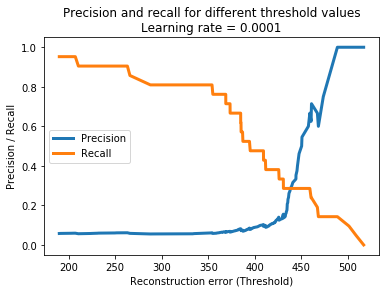

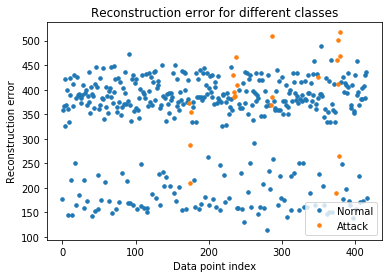

In [30]:
error_df, rmse = validation(model, learning_rate)

# plot the original results (before modification)
plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df)

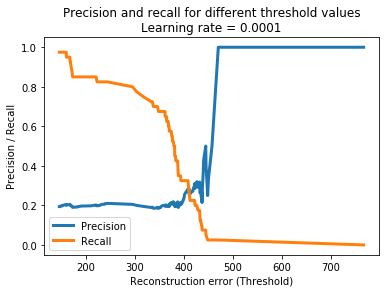

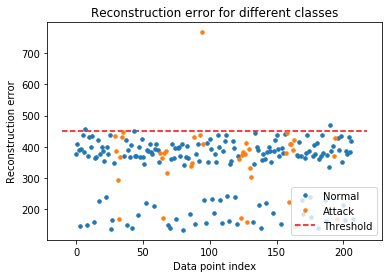

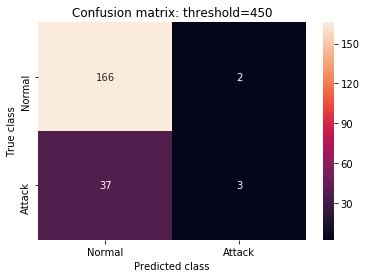

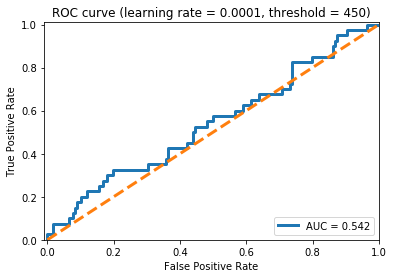

In [31]:
# assign threshold
threshold_fixed = 450

# predict the results for testing dataset
error_df, rmse = evaluation(model, learning_rate)
error_df = tp_anomalous_region(error_df, threshold_fixed)

# plot the results
plot_precision_recall_curve(error_df, learning_rate)
plot_error(error_df, threshold_fixed)
plot_conf_matrix(error_df, threshold_fixed)
plot_roc_curve(error_df, learning_rate, threshold_fixed)